# LIBRARIES

In [1]:
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
df = pd.read_csv("balanced_audio_dataset.csv")
df

,Emotion,Path
0,neutral,RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,neutral,RAVDESS/Actor_01/03-01-02-01-01-01-01.wav
...,...,...
13457,neutral,augmented_data/neutral/03-01-02-02-02-02-01_pi...
13458,neutral,augmented_data/neutral/03-01-01-01-01-01-02_st...
13459,neutral,augmented_data/neutral/03-01-01-01-01-01-02_pi...
13460,neutral,augmented_data/neutral/03-01-01-01-01-02-02_st...


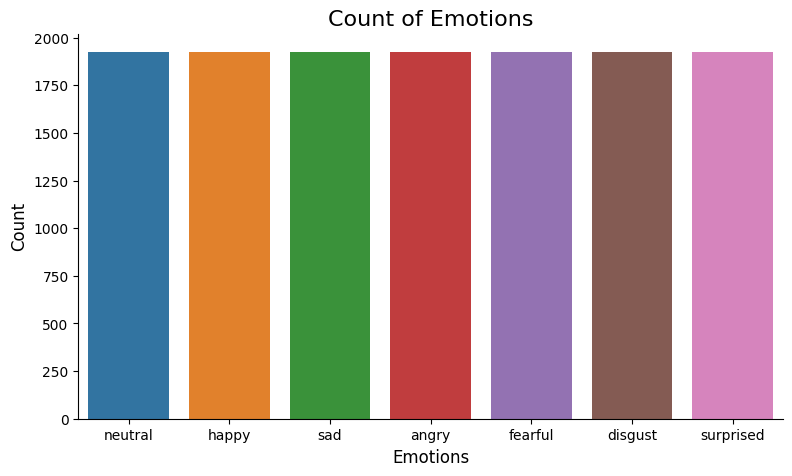

In [3]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(121)
plt.title('Count of Emotions', size=16)
sns.countplot(x=df["Emotion"], hue=df["Emotion"], legend=False)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

## Data Augmentation


In [4]:
def noise(data, noise_factor=0.005):
    return data + noise_factor * np.random.randn(len(data))

def shift(data, shift_max=0.2, sr=22050):
    shift = int(random.uniform(-shift_max, shift_max) * sr)
    return np.roll(data, shift)

def stretch(data, rate=random.uniform(0.9, 1.1)):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sr, n_steps=random.randint(-2, 2)):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def augment_audio(y, sr):
    return [
        noise(y),
        shift(y),
        stretch(y),
        pitch(y, sr=sr)
    ]

### Data Augmentation example

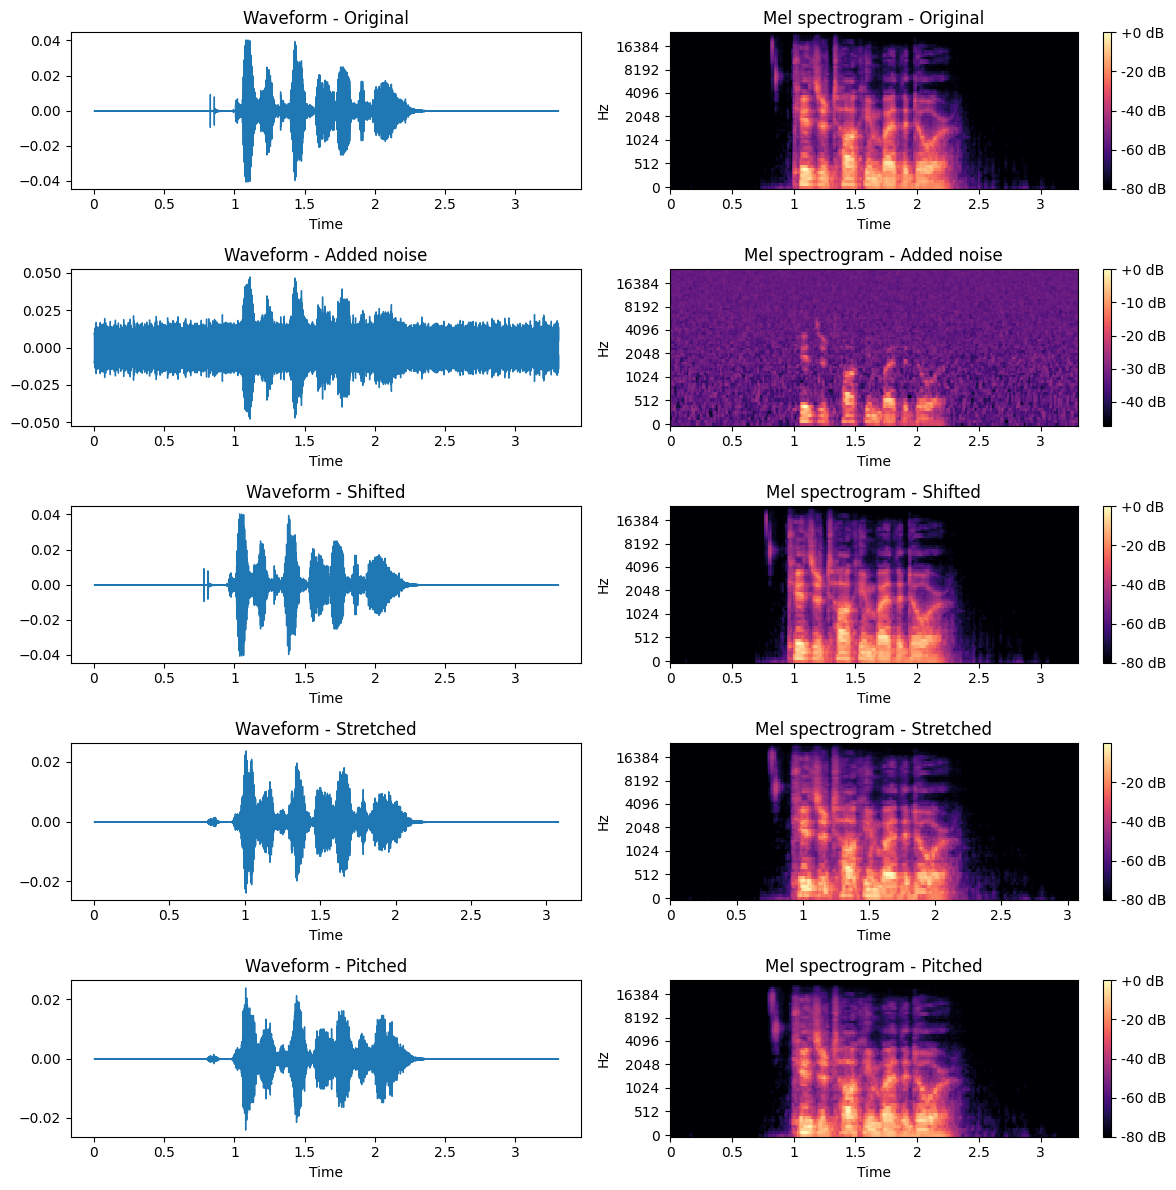

Original Audio:


Added Noise Audio:


Shifted Audio:


Stretched Audio:


Pitched Audio:


In [6]:
example_file = df["Path"].iloc[0]
y, sr = librosa.load(example_file, sr=None)

added_noise, shifted, stretched, pitched = augment_audio(y, sr)

plt.figure(figsize=(12, 12))
for i, (title, data) in enumerate([
    ("Original", y),
    ("Added noise", added_noise),
    ("Shifted", shifted),
    ("Stretched", stretched),
    ("Pitched", pitched)
]):
    # Waveform
    plt.subplot(5, 2, 2 * i + 1)
    librosa.display.waveshow(data, sr=sr)
    plt.title(f"Waveform - {title}")

    # Mel spectrogram
    plt.subplot(5, 2, 2 * i + 2)
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=64)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format="%+2.f dB")
    plt.title(f"Mel spectrogram - {title}")

plt.tight_layout()
plt.show()

# Play the examples
print("Original Audio:")
display(Audio(y, rate=sr))

print("Added Noise Audio:")
display(Audio(added_noise, rate=sr))

print("Shifted Audio:")
display(Audio(shifted, rate=sr))


print("Stretched Audio:")
display(Audio(stretched, rate=sr))

print("Pitched Audio:")
display(Audio(pitched, rate=sr))

# Feature Extraction


In [7]:
def audio_to_melspectrogram_3d(y, sr=16000, n_mels=64, frame_length=2.0, fixed_n_frames=10):
    """
    Convert audio waveform to a 3D array of mel-spectrograms with fixed shape.

    Args:
        y: NumPy array of audio waveform (shape: (n_samples,))
        sr: Sampling rate (default: 22050 Hz)
        n_mels: Number of mel bands (default: 64)
        frame_length: Length of each frame in seconds (default: 2.0)
        fixed_n_frames: Desired number of frames in output (default: 10)

    Returns:
        NumPy array of shape (fixed_n_frames, n_mels, time_steps, channels=1)
    """
    # Calculate samples per frame
    samples_per_frame = int(frame_length * sr)

    # Split audio into frames
    duration = len(y) / sr
    total_frames = int(np.ceil(duration / frame_length))  # Round up to include partial frames
    frames = []

    for i in range(total_frames):
        start = i * samples_per_frame
        end = min(start + samples_per_frame, len(y))
        y_frame = y[start:end]

        # Pad frame if too short
        if len(y_frame) < samples_per_frame:
            y_frame = np.pad(y_frame, (0, samples_per_frame - len(y_frame)), mode='constant')

        # Compute mel-spectrogram for the frame
        mel = librosa.feature.melspectrogram(y=y_frame, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        frames.append(mel_db)

    # Convert to NumPy array and add channel dimension
    frames = np.array(frames)[..., np.newaxis,]  # Shape: (n_frames, n_mels, time_steps, channels=1)

    # Pad or truncate to fixed_n_frames
    current_n_frames = frames.shape[0]
    if current_n_frames < fixed_n_frames:
        # Pad with zero-filled spectrograms
        pad_shape = (fixed_n_frames - current_n_frames, n_mels, frames.shape[2], 1)
        padded_frames = np.zeros(pad_shape)
        frames = np.concatenate([frames, padded_frames], axis=0)
    elif current_n_frames > fixed_n_frames:
        # Truncate excess frames
        frames = frames[:fixed_n_frames]

    return frames

# Data Preparation

In [ ]:
X = df['Path']
y = df['Emotion']

# 60% train, 20% valid, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [ ]:
# Define emotion mappings
emotion_mapping = {'neutral': 0, 'happy': 1, 'sad': 2, 'angry': 3,
                    'fearful': 4, 'disgust': 5, 'surprised': 6}
reverse_mapping = {index: emotion for emotion, index in emotion_mapping.items()}

def process_audio(X, y, emotion_mapping, sr=16000):
    return (
        [audio_to_melspectrogram_3d(*librosa.load(per_X, sr=sr)) for per_X in X],
        [emotion_mapping[per_y] for per_y in y]
    )

# Process valid and test sets
processed_X_val, processed_y_val = process_audio(X_val, y_val, emotion_mapping)
processed_X_test, processed_y_test = process_audio(X_test, y_test, emotion_mapping)
X_val, y_val =np.array(processed_X_val), np.array(processed_y_val)
X_test, y_test = np.array(processed_X_test), np.array(processed_y_test)

In [ ]:
# Augment and process training set
def audio_to_augmented_spectrograms(path, sr=22050):
    y, sr = librosa.load(path, sr=sr)
    tensors = [audio_to_melspectrogram_3d(y, sr)]
    for aug in augment_audio(y, sr):
        tensors.append(audio_to_melspectrogram_3d(aug, sr))
    return tensors


new_X_train, new_y_train = [], []
for per_X, per_y in zip(X_train, y_train):
    tensor = audio_to_augmented_spectrograms(per_X)  # List of spectrograms (original + augmented)
    # Include all spectrograms (original + augmented)
    new_X_train.extend(tensor)
    new_y_train.extend([emotion_mapping[per_y]] * len(tensor))

X_train, y_train = np.array(new_X_train), np.array(new_y_train)

In [ ]:
# Reshape for Pytorch tensor input 
X_train = X_train.transpose(0, 4, 1, 2, 3)
X_val = X_val.transpose(0, 4, 1, 2, 3)
X_test = X_test.transpose(0, 4, 1, 2, 3)

In [ ]:
# Pytorch: (number of samples, 1, fixed_n_frames, n_mels, time_steps)
# TF.Keras: (number of samples, fixed_n_frames, n_mels, time_steps, channels=1)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

# Model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from custom_3D_CNN import *
from timeit import default_timer

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=8)

# Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 50

model = Custom_3D_CNN(num_classes=len(emotion_mapping)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = Adam(model.parameters(), lr=1e-3)
scaler = GradScaler()
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=1e-3, min_lr=1e-5)
early_stopping = EarlyStopping(patience=10, path='checkpoint.pth')

accuracies = {
    "train accuracy": [],
    "valid accuracy": []
}
losses = {
    "train loss": [],
    "valid loss": []
}

for epoch in range(num_epochs):
    # Train
    start_time = default_timer()
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # Forward with Mixed Precision
        with autocast(device_type='cuda'):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

        # Backward
        scaler.scale(loss).backward()
        # Unscale the gradients and clip
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimization step
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * X_batch.size(0)  # multiply by batch size
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == y_batch).sum().item()
        train_total += y_batch.size(0)

    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total
    accuracies["train accuracy"].append(train_accuracy)
    losses["train loss"].append(avg_train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with autocast(device_type='cuda'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            valid_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            valid_correct += (predicted == y_batch).sum().item()
            valid_total += y_batch.size(0)

    avg_valid_loss = valid_loss / valid_total
    valid_accuracy = valid_correct / valid_total

    accuracies["valid accuracy"].append(valid_accuracy)
    losses["valid loss"].append(avg_valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2%} | "
        f"Val Loss: {avg_valid_loss:.4f} | Val Acc: {valid_accuracy:.2%} | "
        f"{default_timer() - start_time:.2f}s")
    
    # Update scheduler every batch
    lr_scheduler.step(avg_valid_loss)
    
    # Early stopping
    early_stopping(avg_valid_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping activated at epoch {epoch+1}")
        break

# Save model
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "best_model.pth")

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracies["train accuracy"], label='Train Accuracy')
plt.plot(accuracies["valid accuracy"], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(losses['train loss'], label='Train Loss')
plt.plot(losses['valid loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [ ]:
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=8, shuffle=True)

# Predict on test data
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_targets, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
print("Classification Report:")
class_names = [reverse_mapping[i] for i in sorted(reverse_mapping.keys())]
report = classification_report(all_targets, all_preds, target_names=class_names)
print(report)

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=per_class_accuracy)
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()